In [1]:
import time
import talib
import calendar
import datetime
import requests
from config import client_id
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Takes date entered and returns the epoch time
def date(year, month, day, hour, minute):
    from datetime import date
    import time

    z = int(time.mktime(time.strptime(f'{year}-{month}-{day} {hour}:{minute}', "%Y-%m-%d %H:%M")))
    
    return z

#For some odd reason there needs to be 3 more 0's for the TDAmeritrade api to properly collect this information

#Jan 25th, 2020
start_date = date(2019, 2, 7, 9, 30)
#Gets today's date as an epoch
end_date = date(2021, 1, 1, 9, 30)

#Today's date
#end_date = calendar.timegm(time.gmtime())

def get_priceHistory(start_date, end_date, symbol):
    
    #Multiply epoch date to add 3 extra zero's
    start_date, end_date = start_date*1000, end_date*1000
    
    payload = {
    'apikey':client_id,
    }


    #endpoint = f'https://api.tdameritrade.com/v1/marketdata/{symbol.upper()}/pricehistory?\
    #periodType=month&frequencyType=daily&needExtendedHoursData=true&frequency=1&startDate={start_Date}&endDate={end_Date}'
    
    endpoint = f'https://api.tdameritrade.com/v1/marketdata/{symbol.upper()}/pricehistory?periodType=month\
    &frequencyType=daily&startDate={start_date}&endDate={end_date}'

    content = requests.get(url = endpoint, params = payload)

    data = content.json()
    
    #The columns on my dataframe
    my_columns = ['datetime', 'open','high', 'low','close','volume']

    dataframe = pd.DataFrame(columns = my_columns)

    #Creating a dictionary of lists
    fields = {key: [] for key in my_columns}

    #Iterates through the keys in the fields dictionary
    #Date is arranged as (Year-Month-Day)
    for key in fields:
        datetime_key = key
        if datetime_key == 'datetime':
            for i in range(0, len(data['candles'])):
                fields[f'{key}'].append(data["candles"][i][f'{key}'])
                epochtime = fields['datetime'][i]
                time_formatted = time.strftime('%Y-%m-%d %H:%M', time.localtime(epochtime/1000))
                fields[f'{key}'][i] = time_formatted 
        else:
            for i in range(0, len(data['candles'])):
                fields[f'{key}'].append(data["candles"][i][f'{key}'])
                
    #Appends to the dataframe the dictionary of lists('fields')
    dataframe = pd.DataFrame(fields)
    
    #Adds the ticker symbol at front of the dataframe
    dataframe.insert(loc=0, column='Ticker', value=f'{symbol.upper()}')
    
    #Changes date into datetime object
    dataframe['datetime'] =  pd.to_datetime(dataframe['datetime'], infer_datetime_format=True)
    
    return dataframe

df_dis = get_priceHistory(start_date, end_date, 'DIS')

In [2]:
df_dis_set_index = df_dis.set_index('datetime')

In [3]:
#GARCH Model to Forecast Volatility

from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
returns = 100*df_dis_set_index.close.pct_change().dropna()

Text(0.5, 0, 'MSFT Returns')

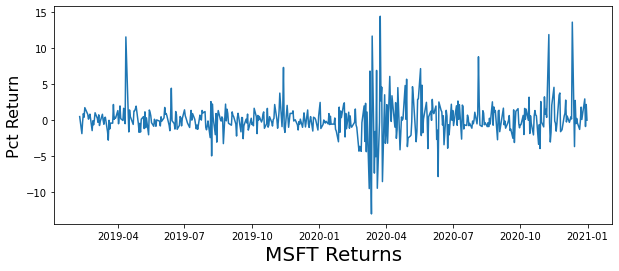

In [5]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.xlabel('MSFT Returns', fontsize=20)

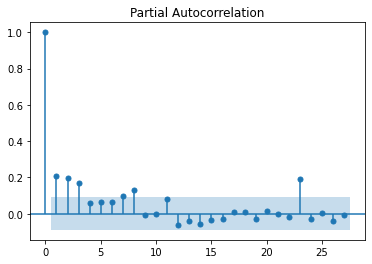

In [6]:
plot_pacf(returns**2)
plt.show()

In [13]:
model = arch_model(returns, p=2, q=0)

In [14]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1475.25413257494
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1853.295387202017
Iteration:      3,   Func. Count:     20,   Neg. LLF: 32615.65000532505
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1133.7112157436097
Iteration:      5,   Func. Count:     32,   Neg. LLF: 579882.5081800048
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1050.5867622650276
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1050.4464766208525
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1050.42160381844
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1050.4208322099735
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1050.4208125052878
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1050.4208109917138
Iteration:     12,   Func. Count:     67,   Neg. LLF: 1050.4208109917136
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1050.4208109917138
            Iterations

In [15]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1050.42
Distribution:                  Normal   AIC:                           2108.84
Method:            Maximum Likelihood   BIC:                           2125.53
                                        No. Observations:                  479
Date:                Wed, Apr 20 2022   Df Residuals:                      478
Time:                        17:25:07   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1464  9.800e-02      1.494      0.135 [-4.565e-02,  0.338]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          3.1751      0.918      3.460  5.408e-04    [  1.376,  4.974]
alpha[1]       0.1026  6.123e-02      1.675  9.397e-02 [-1.746e-02,  0.223]
alpha[2]       0.3950      0.175      2.254  2.423e-02  [5.145e-02,  0.738]
===========================================================================

Covariance estimator: robust
"""

In [16]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\pauln\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

In [17]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])


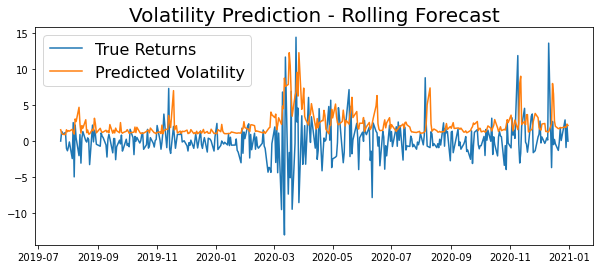

In [22]:
plt.figure(figsize=(10,4))
true = plt.plot(returns[-365:])
preds = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [19]:
#Normalized Average True Range

real = talib.NATR(df_dis['high'], df_dis['low'], df_dis['close'], timeperiod=14)
df_dis['Norm_ATR'] = real
df_dis

,Ticker,datetime,open,high,low,close,volume,Norm_ATR
0,DIS,2019-02-07 01:00:00,111.05,111.1100,109.8100,110.95,8658117,NaN
1,DIS,2019-02-08 01:00:00,110.46,111.5400,110.0641,111.51,6395482,NaN
2,DIS,2019-02-11 01:00:00,111.77,111.8100,109.2500,109.44,11086391,NaN
3,DIS,2019-02-12 01:00:00,110.21,110.8300,109.1500,109.20,7610200,NaN
4,DIS,2019-02-13 01:00:00,109.24,110.4800,109.2300,110.20,6919706,NaN
...,...,...,...,...,...,...,...,...
475,DIS,2020-12-24 01:00:00,173.99,174.5799,172.3800,173.73,2720964,2.698510
476,DIS,2020-12-28 01:00:00,175.75,179.9200,175.0500,178.86,13145438,2.681091
477,DIS,2020-12-29 01:00:00,180.01,180.2000,176.2200,177.30,6875370,2.671831
478,DIS,2020-12-30 01:00:00,178.50,183.4000,178.3700,181.17,11680443,2.668489


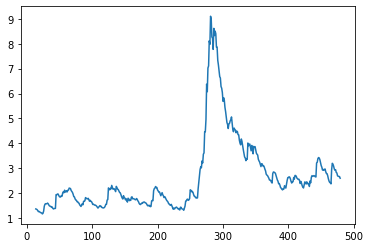

In [21]:
plt.plot(real)

In [23]:
real2 = talib.ATR(df_dis['high'], df_dis['low'], df_dis['close'], timeperiod=14)
df_dis['ATR'] = real2
df_dis

,Ticker,datetime,open,high,low,close,volume,Norm_ATR,ATR
0,DIS,2019-02-07 01:00:00,111.05,111.1100,109.8100,110.95,8658117,NaN,NaN
1,DIS,2019-02-08 01:00:00,110.46,111.5400,110.0641,111.51,6395482,NaN,NaN
2,DIS,2019-02-11 01:00:00,111.77,111.8100,109.2500,109.44,11086391,NaN,NaN
3,DIS,2019-02-12 01:00:00,110.21,110.8300,109.1500,109.20,7610200,NaN,NaN
4,DIS,2019-02-13 01:00:00,109.24,110.4800,109.2300,110.20,6919706,NaN,NaN
...,...,...,...,...,...,...,...,...,...
475,DIS,2020-12-24 01:00:00,173.99,174.5799,172.3800,173.73,2720964,2.698510,4.688122
476,DIS,2020-12-28 01:00:00,175.75,179.9200,175.0500,178.86,13145438,2.681091,4.795399
477,DIS,2020-12-29 01:00:00,180.01,180.2000,176.2200,177.30,6875370,2.671831,4.737156
478,DIS,2020-12-30 01:00:00,178.50,183.4000,178.3700,181.17,11680443,2.668489,4.834502
